In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

In [3]:
ROOT_DIR = "/home/ibrahim/stock/data/processed"
YEARS = ["2020", "2021", "2022", "2023", "2024", "2025"]

data = {
    "2020": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2021": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2022": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2023": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2024": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2025": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    }
}

for year in YEARS:
    PATHS = os.listdir(os.path.join(ROOT_DIR, year))
    
    for path in PATHS:

        with open(os.path.join(ROOT_DIR, year, path), "r") as file:

            if "high" in path:
                data[year]["high_impact"] = json.load(file)
            elif "medium" in path:
                data[year]["medium_impact"] = json.load(file)
            elif "low" in path:
                data[year]["low_impact"] = json.load(file)
            else:
                data[year]["news"] = json.load(file)


In [4]:
PLOTS_DIR = "/home/ibrahim/stock/plots"

corpus = {"2020": {}, "2021": {}, "2022": {}, "2023": {}, "2024": {}, "2025": {}}

for news in data:
    for impact in data[news]:

        if data[news][impact] is None:
            print(f"No data for {news} {impact}")

        if len(data[news][impact]) > 0:
            text = " ".join(data[news][impact])
            text = text.replace("nvidia", " ")

            tokens = word_tokenize(text)

            corpus[news][impact] = text

            if os.path.exists(os.path.join(PLOTS_DIR, f"{news}_{impact}.png")):
                print(f"Already exists {news} {impact}")
                continue
            
            wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=150).generate(text)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"{news} {impact} Word Cloud")
            plt.savefig(os.path.join(PLOTS_DIR, f"{news}_{impact}.png"))
            plt.close()

Already exists 2020 high_impact
Already exists 2020 medium_impact
Already exists 2020 news
Already exists 2021 high_impact
Already exists 2021 medium_impact
Already exists 2021 news
Already exists 2022 high_impact
Already exists 2022 medium_impact
Already exists 2022 news
Already exists 2023 high_impact
Already exists 2023 medium_impact
Already exists 2023 news
Already exists 2024 high_impact
Already exists 2024 medium_impact
Already exists 2024 low_impact
Already exists 2024 news
Already exists 2025 high_impact
Already exists 2025 medium_impact
Already exists 2025 news


In [5]:
import cupy as cp

ROOT_DIR = "/home/ibrahim/stock/data"

embeddings = cp.array([])

for year in YEARS:
    PATHS = os.listdir(os.path.join(ROOT_DIR, year))

    for path in PATHS:

        with open(os.path.join(ROOT_DIR, year, path), "r") as file:
            data = json.load(file)

            for article in data["articles"]:

                if embeddings.shape[0] == 0:
                    embeddings = cp.array(article["embedding"])
                else:
                    embeddings = cp.vstack((embeddings, cp.array(article["embedding"])))

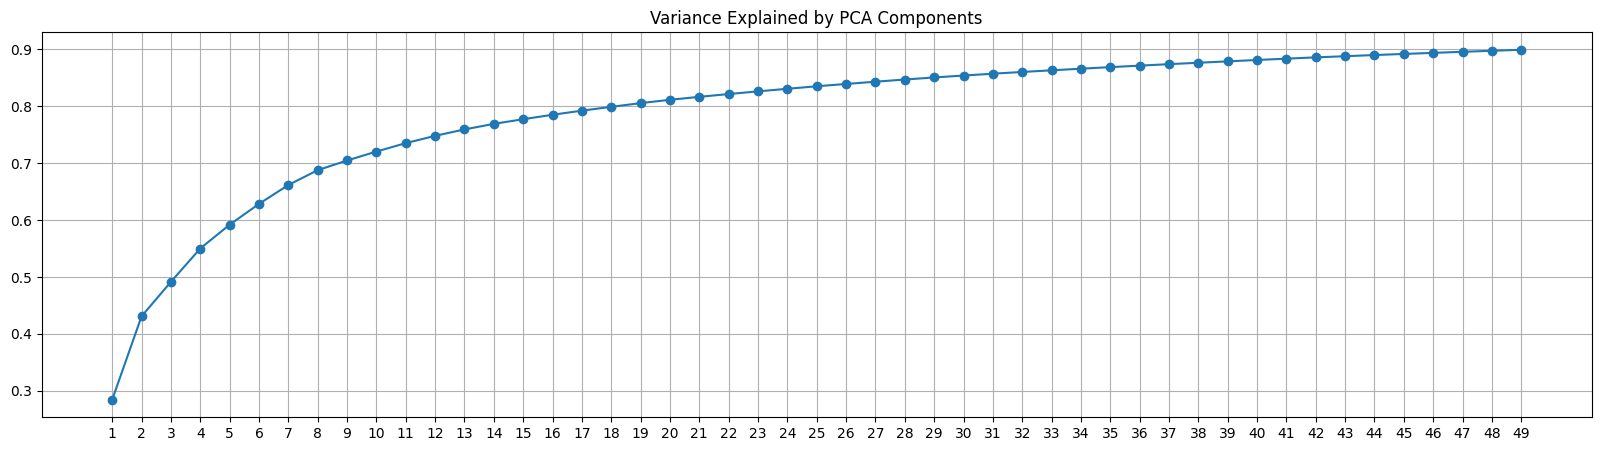

In [6]:
from cuml.decomposition import PCA

variances = []

for k in range(1, 50):
    pca = PCA(n_components=k)
    pca.fit(embeddings)

    variances.append(pca.explained_variance_ratio_.sum().get())

    if pca.explained_variance_ratio_.sum().get() > 0.95:
        print(f"95% variance explained with {k} components")
        break

plt.figure(figsize=(20, 5))
plt.grid(True)
plt.title("Variance Explained by PCA Components")
plt.xticks(range(1,50))
plt.plot(range(1,50), variances, marker='o')
plt.savefig(os.path.join(PLOTS_DIR, "pca_variance_explained.png"))

In [7]:
from cuml.cluster import DBSCAN, KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

dbscan = DBSCAN(eps=0.5, min_samples=5)

dbscan_clusters = dbscan.fit_predict(embeddings)

kmeans_clusters = kmeans.fit_predict(embeddings)

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[2025-04-08 20:48:19.018] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


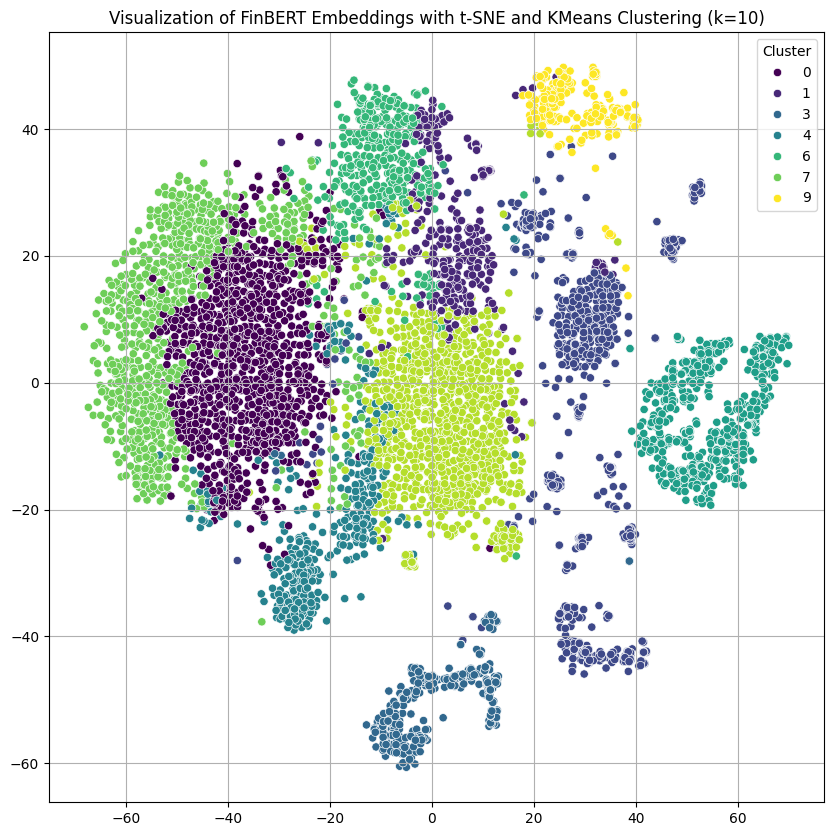

In [8]:
from cuml.decomposition import PCA
from cuml.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=50, n_neighbors=500, n_iter=2000, init="pca")
tsne_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.title("Visualization of FinBERT Embeddings with t-SNE and KMeans Clustering (k=10)")
sns.scatterplot(x=tsne_embeddings[:, 0].get(), y=tsne_embeddings[:, 1].get(), hue=kmeans_clusters.get(), palette="viridis")
plt.grid(True)
plt.legend(title="Cluster")
plt.savefig(os.path.join(PLOTS_DIR, "kmeans_tsne.png"))

In [9]:
import cupy as cp
import polars as pl
import datetime

ROOT_DIR = "/home/ibrahim/stock/data"

date_list = []

sentiment = cp.array([])
sia_scores = cp.array([])

for year in YEARS:
    PATHS = os.listdir(os.path.join(ROOT_DIR, year))

    for path in PATHS:

        with open(os.path.join(ROOT_DIR, year, path), "r") as file:
            data = json.load(file)

            for article in data["articles"]:
                if "published_parsed" in article.keys():
                    date = datetime.datetime(year = article["published_parsed"][0], month = article["published_parsed"][1], day = article["published_parsed"][2], hour = article["published_parsed"][3], minute = article["published_parsed"][4], second = article["published_parsed"][5])
                else:
                    date = None

                date_list.append(date)

                if sia_scores.shape[0] == 0:
                    sia_scores = cp.array([article["sentiment_scores"]["pos"], article["sentiment_scores"]["neu"], article["sentiment_scores"]["neg"], article["sentiment_scores"]["compound"]])
                else:
                    sia_scores = cp.vstack((sia_scores, cp.array([article["sentiment_scores"]["pos"], article["sentiment_scores"]["neu"], article["sentiment_scores"]["neg"], article["sentiment_scores"]["compound"]])))

                if sentiment.shape[0] == 0:
                    sentiment = cp.array([article["finbert_sentiment"]["positive"], article["finbert_sentiment"]["neutral"], article["finbert_sentiment"]["negative"]])
                else:
                    sentiment = cp.vstack((sentiment, cp.array([article["finbert_sentiment"]["positive"], article["finbert_sentiment"]["neutral"], article["finbert_sentiment"]["negative"]])))

In [10]:
date_series = pl.Series("date", date_list)

In [11]:
import polars as pl

df = pl.DataFrame({
    "date": date_series,
    "embeddings": embeddings.get(),
    "finbert_positive": sentiment[:, 0].get(),
    "finbert_neutral": sentiment[:, 1].get(),
    "finbert_negative": sentiment[:, 2].get(),
    "sia_positive": sia_scores[:, 0].get(),
    "sia_neutral": sia_scores[:, 1].get(),
    "sia_negative": sia_scores[:, 2].get(),
    "sia_compound": sia_scores[:, 3].get(),
    "kmeans_clusters": kmeans_clusters.get(),
    "dbscan_clusters": dbscan_clusters.get()
})

In [12]:
df.head()

date,embeddings,finbert_positive,finbert_neutral,finbert_negative,sia_positive,sia_neutral,sia_negative,sia_compound,kmeans_clusters,dbscan_clusters
datetime[μs],"array[f64, 768]",f64,f64,f64,f64,f64,f64,f64,i32,i32
2020-01-08 08:00:00,"[0.589647, 0.507539, … -0.088602]",0.041835,0.943506,0.014659,0.053,0.901,0.046,0.8588,2,0
2020-01-10 08:00:00,"[0.263935, 0.607964, … -0.044931]",0.047654,0.938869,0.013477,0.083,0.852,0.065,0.9599,2,-1
2020-01-16 08:00:00,"[-0.173968, 0.457967, … 0.038417]",0.161678,0.827436,0.010886,0.08,0.89,0.031,0.9802,7,-1
2020-01-15 08:00:00,"[0.021052, 0.489439, … 0.139318]",0.314194,0.676977,0.008829,0.083,0.917,0.0,0.991,0,-1
2020-01-16 08:00:00,"[-0.079407, 0.604463, … -0.255625]",0.032132,0.174779,0.793089,0.142,0.854,0.005,0.9989,8,-1


In [13]:
def sentiment_classifier(pos, neu, neg) -> str:
    if pos > neu and pos > neg:
        return str("positive")
    elif neu > pos and neu > neg:
        return str("neutral")
    else:
        return str("negative")
    
df = df.with_columns(
    pl.struct(["finbert_positive", "finbert_neutral", "finbert_negative"])
      .map_elements(lambda x: sentiment_classifier(x["finbert_positive"], x["finbert_neutral"], x["finbert_negative"]))
        .alias("finbert_sentiment"),
)

/tmp/ipykernel_6017/1146418757.py:9: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(


In [14]:
df = df.sort("date")

In [15]:
sentiments = df.group_by_dynamic("date", every="1mo").agg(pl.col("finbert_sentiment").value_counts())

In [19]:
struct_list = sentiments["finbert_sentiment"].to_list()

all_values = {
    "positive": [],
    "neutral": [],
    "negative": []
}

for struct in struct_list:
    new_vals = {
        "positive": 0,
        "neutral": 0,
        "negative": 0
    }
    for val in struct:
        if val["finbert_sentiment"] == "positive":
            new_vals["positive"] = val["count"]
        elif val["finbert_sentiment"] == "neutral":
            new_vals["neutral"] = val["count"]
        elif val["finbert_sentiment"] == "negative":
            new_vals["negative"] = val["count"]
    
    all_values["positive"].append(new_vals["positive"])
    all_values["neutral"].append(new_vals["neutral"])
    all_values["negative"].append(new_vals["negative"])


In [30]:
sentiments = sentiments.with_columns(
    pl.Series("positive", all_values["positive"]),
    pl.Series("neutral", all_values["neutral"]),
    pl.Series("negative", all_values["negative"])
)

Fetching stock indicators for ('NVDA',) for the period 5y and timeframe 1mo


Traceback (most recent call last):
  File "/home/ibrahim/.local/bin/indicators", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/lib/python3/dist-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/click/core.py", line 1434, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/click/core.py", line 783, in invoke
    return __callback(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ibrahim/.local/lib/python3.12/site-packages/src/cli.py", line 25, in main
    src.indicators.run_main(ticker, period, timeframe, output, format, dir, config_json, engine)
  File "/home/ibrahim/.local/lib/python3.12/site-packages/src/

CompletedProcess(args=['indicators', 'NVDA', '-p', '5y', '-t', '1mo', '-o', 'NVDA_indicators.csv'], returncode=1)

In [50]:
sentiments["date"].min()

datetime.datetime(2020, 1, 1, 0, 0)

In [53]:
df_indicators = pl.read_csv("NVDA_10y.csv")

df_indicators = df_indicators.with_columns(
    pl.col("date").str.strptime(pl.Datetime)
)

df_indicators = df_indicators.filter(pl.col("date") >= sentiments["date"].min())

df_indicators.head()

date,close,high,low,open,volume,dividends,stock splits,sma_200,macd,signal_line,macd_hist,returns,rsi,bb_lower,bb_upper,roc,hi_lo,hi_close,lo_close,true_range,ATR,obv,K,D
datetime[μs],f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-01-01 00:00:00,5.885532,6.459821,5.757083,5.943285,6125412000,0.0,0.0,null,0.727235,0.796312,-0.069077,0.028128,-321.614754,null,null,null,0.702739,0.602418,0.100321,0.702739,0.712383,2.89264,-413.800123,-413.974208
2020-02-01 00:00:00,6.722946,7.874263,5.861138,5.867361,11848652000,0.004,0.0,null,0.772265,0.79378,-0.021516,0.837414,-237.235715,null,null,null,2.013125,1.988731,0.024394,2.013125,0.751504,3.034924,-475.172326,-434.2669
2020-03-01 00:00:00,6.56581,7.096106,4.500419,6.897089,15773952000,0.0,0.0,null,0.804603,0.79492,0.009683,-0.157136,-287.767787,null,null,null,2.595687,0.37316,2.222526,2.595687,0.800007,3.011551,-475.329462,-454.767303
2020-04-01 00:00:00,7.280177,7.577083,5.937873,6.367789,11278304000,0.0,0.0,null,0.855936,0.801342,0.054593,0.714367,-284.917599,null,null,null,1.63921,1.011273,0.627937,1.63921,0.829195,3.120352,-474.615094,-475.03896
2020-05-01 00:00:00,8.842921,9.148048,6.995229,7.082656,12548876000,0.0,0.0,null,0.953591,0.817368,0.136222,1.562744,-155.318563,null,null,null,2.152819,1.867871,0.284949,2.152819,0.8697,3.335009,-600.430831,-516.791795


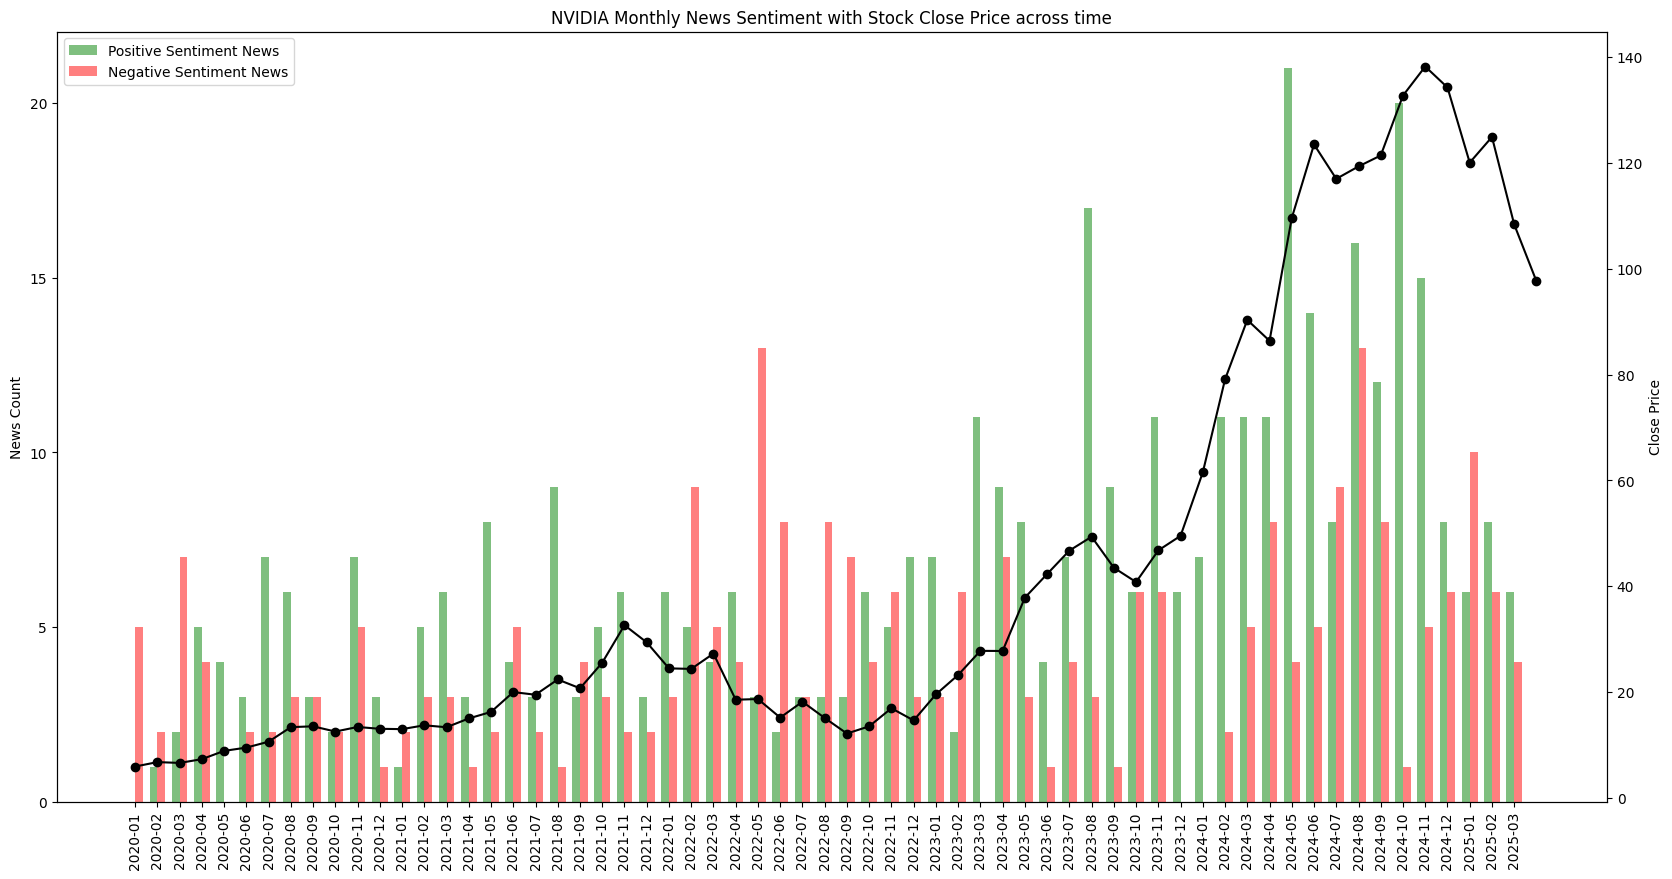

In [91]:
import numpy as np

fig, ax1 = plt.subplots()

fig.set_size_inches(20, 10)

ax2 = plt.twinx()

ax2.plot(df_indicators["date"].dt.strftime("%Y-%m").to_list(), df_indicators["close"].to_list(), label="Close Price", color="black", marker="o")

# get x positions based on the number of unique dates in sentiments dataframe
x = np.arange(len(sentiments["date"]))
width = 0.35

ax1.bar(x - width/2, sentiments["positive"].to_list(), width, color="green", alpha=0.5, label="Positive Sentiment News")
ax1.bar(x + width/2, sentiments["negative"].to_list(), width, color="red", alpha=0.5, label="Negative Sentiment News")

ax1.legend(loc="upper left")
# update x-tick labels
ax1.set_xticks(x)
ax1.set_xticklabels(sentiments["date"].dt.strftime("%Y-%m").to_list(), rotation=90)

ax1.set_yticks(range(0, 25, 5))
ax1.set_ylabel("News Count")

ax2.set_yticks(range(0, 160, 20))
ax2.set_ylabel("Close Price")

plt.title("NVIDIA Monthly News Sentiment with Stock Close Price across time")
plt.savefig(os.path.join(PLOTS_DIR, "sentiment_close_price.png"))

TypeError: unsupported operand type(s) for +: 'int' and 'str'

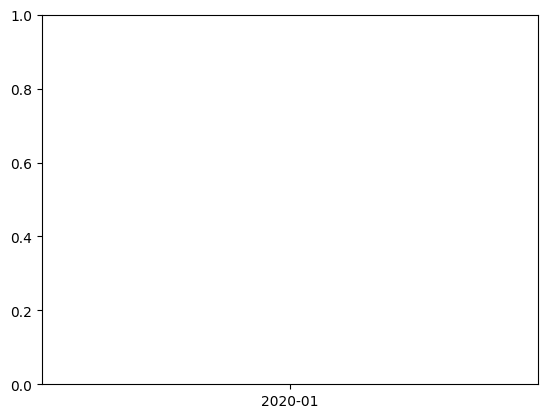

In [17]:
plt.bar(sentiments["date"].dt.strftime("%Y-%m").to_list(), sentiments["finbert_sentiment"])